In [2]:
# --- Project Setup ---
from setup_notebook import setup_project_root
setup_project_root()

# --- Imports ---
from src.project_config import PROCESSED_DIR, PROTEIN_IDS_CSV, get_paths_protein, get_paths, COLORS_MODELS
from src.statistics.statistics_per_2D import compute_2D_statistics
import pandas as pd
from tqdm.notebook import tqdm
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


- 1. Computing Mean Rank Scores per 2D-Structure from DSSP
- 2. additionally correlation of ESM1b and AlphaMissense with rASA
- 3. correlation between ESM1b and AlphaMissense per structure
- 4. average difference rank score per difference cluster
  - what structures percentually in difference clusters?

#### 1.1 Compute Mean Rank Scores per 2D-Structure

- Ignore cells in column "2D_Structures" which are "", only consider "-" and other with non-null value

In [4]:
# Example
result = compute_2D_statistics("P05067", feature = "Topology")
result.head(10)

,Topological domain,AM_mean,ESM_mean,count
0,Cytoplasmic,0.802531,0.847490,48
1,Extracellular,0.565380,0.558230,684
2,Transmembrane,0.811057,0.867424,21


In [5]:
result = compute_2D_statistics("P05067", feature = "2D")
result.head(10)

,2D_Structures,AM_mean,ESM_mean,count,Structure
1,B,0.578633,0.768100,3,Beta bridge
5,I,0.636160,0.648600,5,Helix-5
3,G,0.571862,0.459062,8,Helix-3
6,P,0.543093,0.461147,15,κ‐helix
7,S,0.559335,0.570035,31,Bend
8,T,0.518563,0.556042,52,Turn
2,E,0.698908,0.743724,74,Strand
4,H,0.712670,0.709000,273,Alpha helix
0,-,0.448992,0.443360,309,Disorded


In [6]:
protein_ids = pd.read_csv(PROTEIN_IDS_CSV)
save_path = PROCESSED_DIR / "6.4.Rankscore_per_structure"
count_error = 0

for protein in tqdm(protein_ids["Protein_ID"], desc="Computing 2D statistics"):
    try:
        result_2D = compute_2D_statistics(protein, feature = "2D")
        result_topology = compute_2D_statistics(protein, feature = "Topology")
    except Exception as e:
        print(f"Error processing {protein}: {e}")
        count_error += 1
        print(f"Total errors so far: {count_error}")
        continue
    # Save results to CSV
    result_2D.to_csv(save_path / "2D_Rankscores" / f"{protein}_2D_statistics.csv", index=False)
    result_topology.to_csv(save_path / "Topology_Rankscores" / f"{protein}_Topology_statistics.csv", index=False)

Computing 2D statistics:   0%|          | 0/20246 [00:00<?, ?it/s]

Error processing Q8N841: [Errno 2] No such file or directory: '/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/5.2.Protein_Statistics/DSSP_ALL_HUMAN_PROTEOME/Q8N841_statistics.csv'
Total errors so far: 1
Error processing Q9BRI3: [Errno 2] No such file or directory: '/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/5.2.Protein_Statistics/DSSP_ALL_HUMAN_PROTEOME/Q9BRI3_statistics.csv'
Total errors so far: 2
Error processing Q07654: [Errno 2] No such file or directory: '/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/5.2.Protein_Statistics/DSSP_ALL_HUMAN_PROTEOME/Q07654_statistics.csv'
Total errors so far: 3
Error processing Q9NS71: [Errno 2] No such file or directory: '/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/5.2.Protein_Statistics/DSSP_ALL_HUMAN_PROTEOME/Q9NS71_statistics.csv'
Total errors so far: 4
Error processing Q9NVI7: [Errno 2] No such file or directory: '/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/5.2.Protein_Statistics/

KeyboardInterrupt: 

In [7]:
# Compute the overall statistics
# 1. Human Proteome
human_proteome_ids = pd.read_csv(PROTEIN_IDS_CSV) #"Protein_ID"

# 2. N_out Proteome
n_out_proteome_ids = pd.read_csv(PROCESSED_DIR / "Human_N_Out_Proteome.csv", usecols=["entry"]) #"entry"

# 3. Multispan Proteome
multispan_proteome_ids = pd.read_csv(PROCESSED_DIR / "Multispan_proteome_cleaned.csv") #"Entry"




# Structures: each will hold total weighted AM/ESM and total count
aggregated_data = defaultdict(lambda: {'AM_sum': 0.0, 'ESM_sum': 0.0,
                                       'count': 0, 'percentage': 0.0 })

input_2D = PROCESSED_DIR / "6.4.Rankscore_per_structure" / "2D_Rankscores" 
input_topology = PROCESSED_DIR / "6.4.Rankscore_per_structure" / "Topology_Rankscores"

# Loop through all CSV files in the directory
for protein_id in tqdm(multispan_proteome_ids["Entry"], desc="Processing Proteins"):

    try:
        df = pd.read_csv(input_2D / f"{protein_id}_2D_statistics.csv")
    except FileNotFoundError:
        print(f"File not found for {protein_id}, skipping.")

    
    for _, row in df.iterrows():        # _ row index, row = row data itself
        key = row['Structure']
        count = int(row['count'])
        am_mean = float(row['AM_mean'])
        esm_mean = float(row['ESM_mean'])
        

        aggregated_data[key]['AM_sum'] += am_mean * count
        aggregated_data[key]['ESM_sum'] += esm_mean * count
        aggregated_data[key]['count'] += count
     


# Calculate total count for percentage calculation
total_count = sum(data['count'] for data in aggregated_data.values())   

# Prepare final result
final_rows = []
for key, data in aggregated_data.items():
    count = data['count']
    am_weighted = data['AM_sum'] / count
    esm_weighted = data['ESM_sum'] / count
    percentage = (count / total_count) * 100
    final_rows.append({
        'Structure': key,
        'AM_mean': am_weighted,
        'ESM_mean': esm_weighted,
        'count': count,
        'percentage': percentage
    }) # Sort by structure code



# Create final DataFrame and save or display
final_df = pd.DataFrame(final_rows)
final_df = final_df.sort_values(by='count', ascending=False)  # Optional: sort by code
final_df.to_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / 'multispan_proteome_structures.csv',
                index=False)

print(final_df)

Processing Proteins:   0%|          | 0/2822 [00:00<?, ?it/s]

File not found for O60721, skipping.
File not found for P02708, skipping.
File not found for P03999, skipping.
File not found for P18507, skipping.
File not found for P29973, skipping.
File not found for P34998, skipping.
File not found for Q03518, skipping.
File not found for Q0D2K0, skipping.
File not found for Q13507, skipping.
File not found for Q2M3C6, skipping.
File not found for Q3KNS1, skipping.
File not found for Q8N8Q8, skipping.
File not found for Q8NBS3, skipping.
File not found for Q8TAX9, skipping.
File not found for Q8TDS5, skipping.
File not found for Q8WUG5, skipping.
File not found for Q92581, skipping.
File not found for Q93086, skipping.
File not found for Q96FT7, skipping.
File not found for Q96HE8, skipping.
File not found for Q99705, skipping.
File not found for Q9BRI3, skipping.
File not found for Q9H252, skipping.
File not found for Q9H310, skipping.
File not found for Q9HBW0, skipping.
File not found for Q9Y2W3, skipping.
File not found for Q9Y5I7, skipping.
F

In [3]:
csv_multispan = pd.read_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / 'multispan_proteome_structures.csv')
csv_nout = pd.read_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / 'n_out_proteome_structures.csv')
csv_human = pd.read_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / 'human_proteome_structures.csv')


# Reshape the data into a long format
long_df = final_df.melt(id_vars='Structure', value_vars=['AM_mean', 'ESM_mean'], 
                        var_name='Type', value_name='Mean_Rank_Score')

# Plot the data
plt.figure(figsize=(15, 8))
sns.barplot(data=long_df, x='Structure', y='Mean_Rank_Score',
            hue='Type', palette=[COLORS_MODELS['AM'], COLORS_MODELS['ESM']])
plt.xticks(rotation=90)
plt.xlabel('Structure')
plt.ylabel('Mean Rank Score')
plt.title('Mean Rank Scores for Human Proteome Structures')
plt.legend(title='Type')
plt.tight_layout()


NameError: name 'final_df' is not defined

### 1.2 

AttributeError: Rectangle.set() got an unexpected keyword argument 'fontweight'

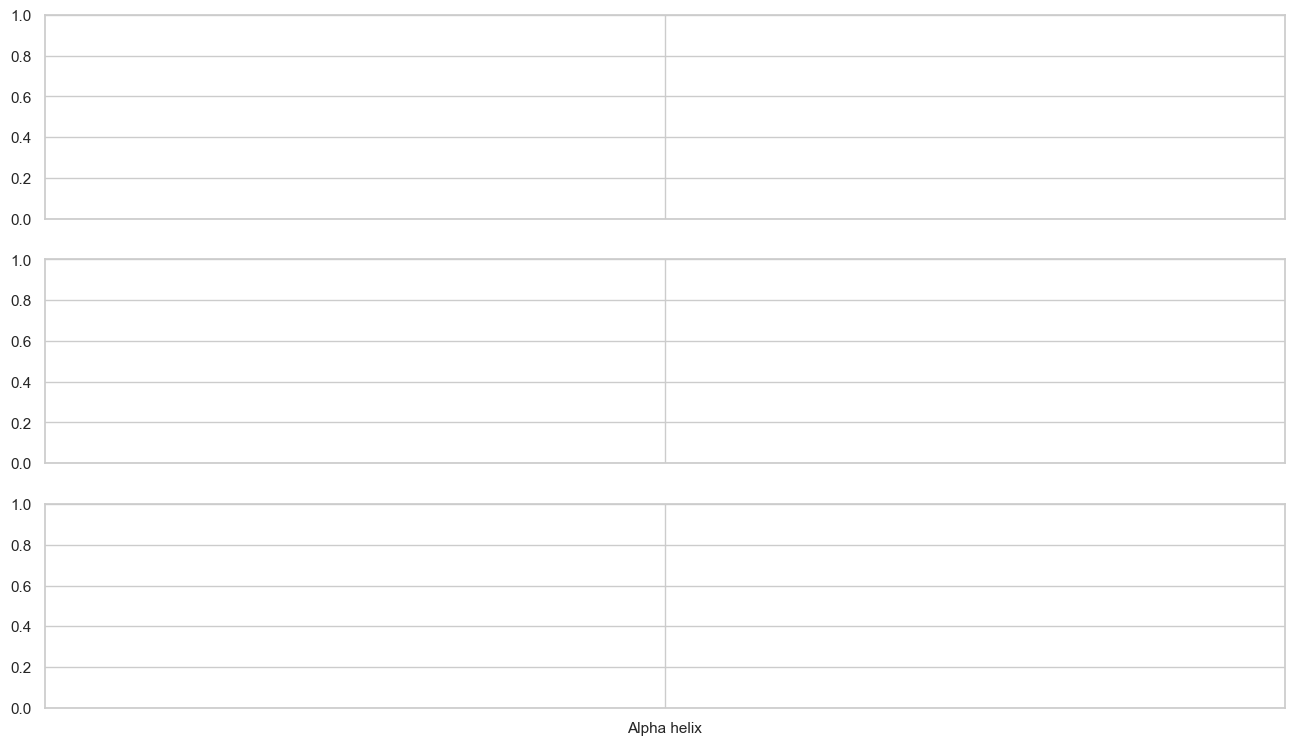

In [13]:

# Load your datasets
csv_human = pd.read_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / 'human_proteome_structures.csv')
csv_multispan = pd.read_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / 'multispan_proteome_structures.csv')
csv_nout = pd.read_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / 'n_out_proteome_structures.csv')

# Add a dataset label column
csv_human['Dataset'] = 'Human'
csv_multispan['Dataset'] = 'Multispan'
csv_nout['Dataset'] = 'N-Out'

# Combine all data
combined_df = pd.concat([csv_human, csv_multispan, csv_nout], ignore_index=True)

# Melt for long format
long_df = combined_df.melt(id_vars=['Structure', 'Dataset'], 
                           value_vars=['AM_mean', 'ESM_mean'],
                           var_name='Type', value_name='Mean_Rank_Score')

# Sort structure order for consistent x-axis
structure_order = sorted(long_df['Structure'].unique())

# Set plot styles
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 9), sharex=True, gridspec_kw={'hspace': 0.2})

datasets = ['Human', 'Multispan', 'N-Out']
titles = ['Human Proteome', 'Multispan Proteome', 'N-Out Proteome']
colors = [COLORS_MODELS['AM'], COLORS_MODELS['ESM']]

for ax, dataset, title in zip(axes, datasets, titles):
    data = long_df[long_df['Dataset'] == dataset]
    sns.barplot(data=data, x='Structure', y='Mean_Rank_Score', hue='Type', 
                palette=colors, ax=ax, order=structure_order, fontweight='bold')
    
    ax.set_title(title, fontsize=14)
    ax.set_ylabel("Mean Rank Score")
    ax.legend().set_visible(False)  # Hide individual legends

    #if ax != axes[-1]:
        #ax.set_xlabel("")
        #ax.set_xticklabels([])
    #else:
    ax.set_xlabel("Structure")
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Add a single legend outside the plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', title='Type')

plt.tight_layout(rect=[0, 0, 0.97, 1])  # leave space for legend
plt.show()

/var/folders/kw/jxgfh6fx7_v_5_3hk6sqf3nw0000gn/T/ipykernel_2542/4164495847.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/Users/doma/Documents/Bachelor_Arbeit/Code/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


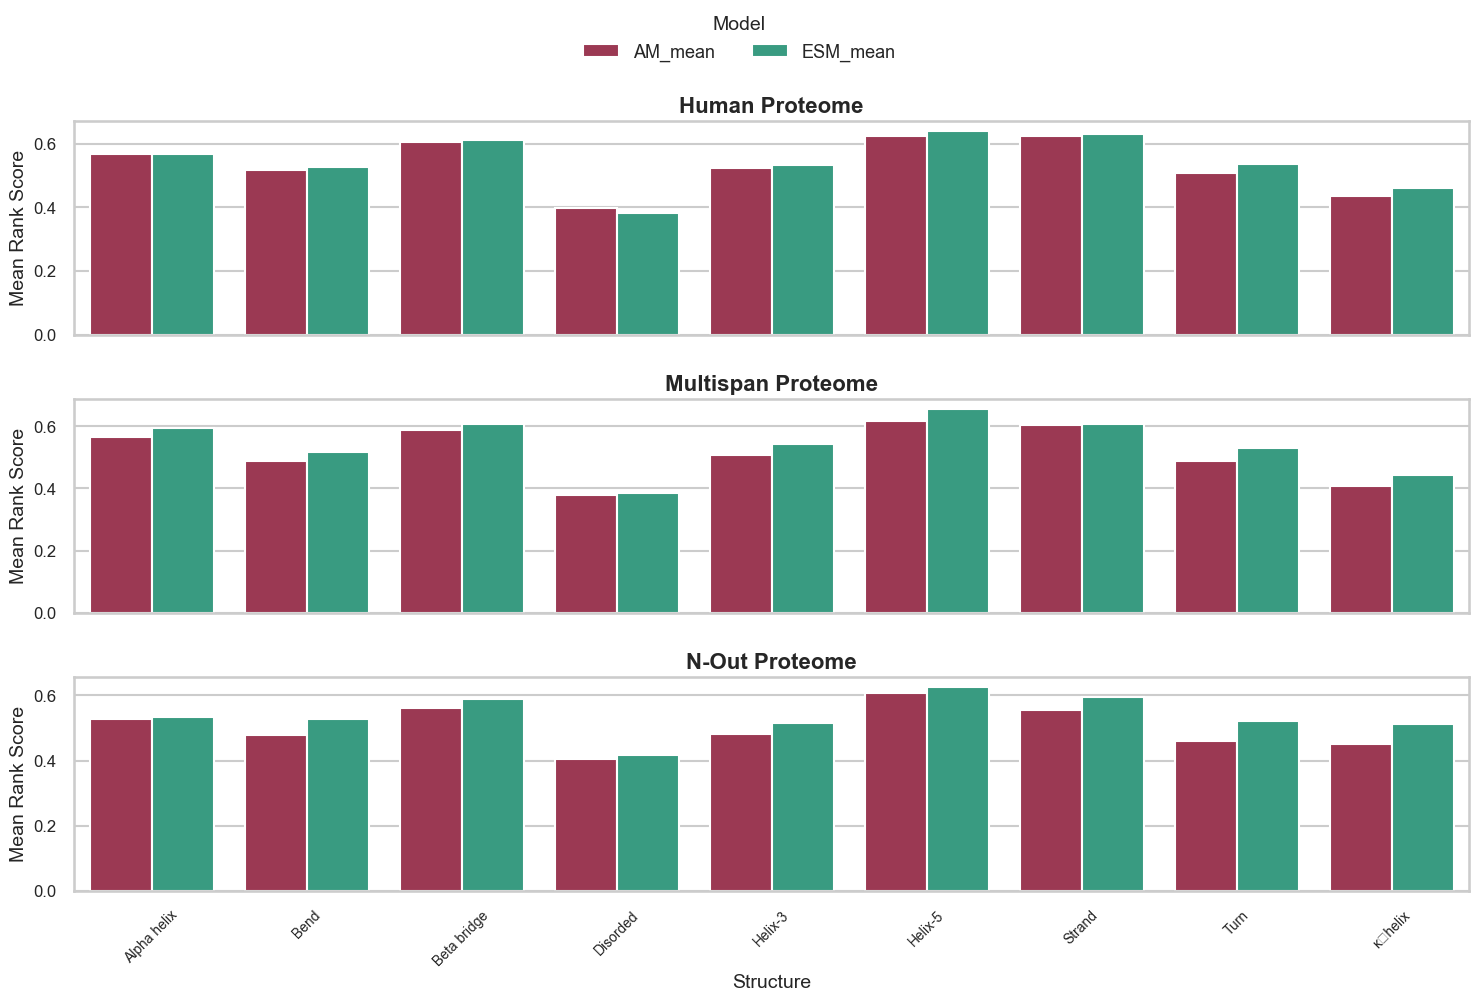

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your datasets
csv_human = pd.read_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / 'human_proteome_structures.csv')
csv_multispan = pd.read_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / 'multispan_proteome_structures.csv')
csv_nout = pd.read_csv(PROCESSED_DIR / "6.4.Rankscore_per_structure" / 'n_out_proteome_structures.csv')

# Add dataset labels
csv_human['Dataset'] = 'Human'
csv_multispan['Dataset'] = 'Multispan'
csv_nout['Dataset'] = 'N-Out'

# Combine all data
combined_df = pd.concat([csv_human, csv_multispan, csv_nout], ignore_index=True)

# Melt for long format
long_df = combined_df.melt(
    id_vars=['Structure', 'Dataset'], 
    value_vars=['AM_mean', 'ESM_mean'],
    var_name='Model', 
    value_name='Mean Rank Score'
)

# Sort structures alphabetically or by overall score (optional)
structure_order = sorted(long_df['Structure'].unique())

# Set seaborn theme
sns.set_theme(style="whitegrid", context="talk")

# Set custom color palette


palette = {
    'AM_mean': COLORS_MODELS['AM'],  # Blue
    'ESM_mean': COLORS_MODELS['ESM']  # Orange
}

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 10), sharex=True, gridspec_kw={'hspace': 0.3})

datasets = ['Human', 'Multispan', 'N-Out']
titles = ['Human Proteome', 'Multispan Proteome', 'N-Out Proteome']

for ax, dataset, title in zip(axes, datasets, titles):
    data = long_df[long_df['Dataset'] == dataset]
    
    sns.barplot(
        data=data, 
        x='Structure', 
        y='Mean Rank Score', 
        hue='Model',
        palette=palette, 
        ax=ax,
        order=structure_order
    )
    
    ax.set_title(title, fontsize=16, weight='bold')
    ax.set_ylabel("Mean Rank Score", fontsize=14)
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend().set_visible(False)  # Hide individual legends

# Add single legend at the top center
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc='upper center', ncol=2, 
    fontsize=13, title='Model', title_fontsize=14,
    frameon=False
)

# Global x-axis label
axes[-1].set_xlabel("Structure", fontsize=14)

# Adjust layout to accommodate legend
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
